<a href="https://colab.research.google.com/github/MariaRosendal/Tesla-tweets/blob/main/Preprocessing_for_sentiment_analysis_fill_forward.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing data

In [1]:
# Enable making data frames
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [141]:
tweets_raw = pd.read_csv('https://raw.githubusercontent.com/MariaRosendal/Tesla-tweets/main/tweets.csv')

In [142]:
tweets_raw.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1328458535340949505,1328428879334297600,2020-11-16 22:02:51 UTC,2020-11-16,22:02:51,0,44196397,elonmusk,Elon Musk,NaN,@Maisie_Williams 🎶 Toss a bitcoin to ur Witcher 🎶,en,[],[],[],1148,3448,66981,[],[],https://twitter.com/elonmusk/status/1328458535...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'Maisie_Williams', 'name': 'M...",NaN,NaN,NaN,NaN
1,1328451518010327042,1328143001697230848,2020-11-16 21:34:57 UTC,2020-11-16,21:34:57,0,44196397,elonmusk,Elon Musk,NaN,@Kristennetten 😉,und,[],[],[],100,37,2203,[],[],https://twitter.com/elonmusk/status/1328451518...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'Kristennetten', 'name': 'K10...",NaN,NaN,NaN,NaN
2,1328424097110323200,1328352029190877185,2020-11-16 19:46:00 UTC,2020-11-16,19:46:00,0,44196397,elonmusk,Elon Musk,NaN,"@WhatsupFranks @michaelmina_lab CureVac, Moder...",en,[],[],[],72,75,1090,[],[],https://twitter.com/elonmusk/status/1328424097...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'WhatsupFranks', 'name': 'fra...",NaN,NaN,NaN,NaN
3,1328421992144355328,1328352029190877185,2020-11-16 19:37:38 UTC,2020-11-16,19:37:38,0,44196397,elonmusk,Elon Musk,NaN,@michaelmina_lab Creating synthetic mRNA for c...,en,[],[],[],96,90,1221,[],[],https://twitter.com/elonmusk/status/1328421992...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'michaelmina_lab', 'name': 'M...",NaN,NaN,NaN,NaN
4,1328419837656276992,1328338500064845825,2020-11-16 19:29:04 UTC,2020-11-16,19:29:04,0,44196397,elonmusk,Elon Musk,NaN,@gaertner_anne @Neuro_Skeptic @DresdenTea @jud...,tl,[],[],[],55,32,1412,[],[],https://twitter.com/elonmusk/status/1328419837...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'gaertner_anne', 'name': 'Ann...",NaN,NaN,NaN,NaN


In [5]:
tweets_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10230 entries, 0 to 10229
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               10230 non-null  int64  
 1   conversation_id  10230 non-null  int64  
 2   created_at       10230 non-null  object 
 3   date             10230 non-null  object 
 4   time             10230 non-null  object 
 5   timezone         10230 non-null  int64  
 6   user_id          10230 non-null  int64  
 7   username         10230 non-null  object 
 8   name             10230 non-null  object 
 9   place            0 non-null      float64
 10  tweet            10230 non-null  object 
 11  language         10230 non-null  object 
 12  mentions         10230 non-null  object 
 13  urls             10230 non-null  object 
 14  photos           10230 non-null  object 
 15  replies_count    10230 non-null  int64  
 16  retweets_count   10230 non-null  int64  
 17  likes_count 

In [6]:
tweets_raw.describe().round(2)

,id,conversation_id,timezone,user_id,place,replies_count,retweets_count,likes_count,video,near,geo,source,user_rt_id,user_rt,retweet_id,retweet_date,translate,trans_src,trans_dest
count,1.023000e+04,1.023000e+04,10230.0,10230.0,0.0,10230.00,10230.00,10230.00,10230.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,1.093816e+18,1.091027e+18,0.0,44196397.0,NaN,557.39,2226.22,19569.01,0.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.653157e+17,1.701199e+17,0.0,0.0,NaN,1932.38,10115.00,59726.37,0.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,6.675167e+17,1.659576e+09,0.0,44196397.0,NaN,0.00,0.00,57.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.000081e+18,9.993676e+17,0.0,44196397.0,NaN,47.00,44.00,1018.25,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.119283e+18,1.117901e+18,0.0,44196397.0,NaN,110.00,129.00,2625.50,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,1.238623e+18,1.237239e+18,0.0,44196397.0,NaN,376.00,858.50,11936.25,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,1.328459e+18,1.328429e+18,0.0,44196397.0,NaN,47526.00,372865.00,1638662.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
elon_musk = tweets_raw.loc[:,['date', 'username', 'tweet', 'replies_count', 'retweets_count', 'likes_count']]
elon_musk.head()

,date,username,tweet,replies_count,retweets_count,likes_count
0,2020-11-16,elonmusk,@Maisie_Williams 🎶 Toss a bitcoin to ur Witcher 🎶,1148,3448,66981
1,2020-11-16,elonmusk,@Kristennetten 😉,100,37,2203
2,2020-11-16,elonmusk,"@WhatsupFranks @michaelmina_lab CureVac, Moder...",72,75,1090
3,2020-11-16,elonmusk,@michaelmina_lab Creating synthetic mRNA for c...,96,90,1221
4,2020-11-16,elonmusk,@gaertner_anne @Neuro_Skeptic @DresdenTea @jud...,55,32,1412


In [8]:
# Make dates to datetime format
elon_musk['date'] = pd.to_datetime(elon_musk.date)

In [9]:
#Set the date as index
elon_musk.set_index('date', inplace=True)

## Exploratory data analysis

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("dark")

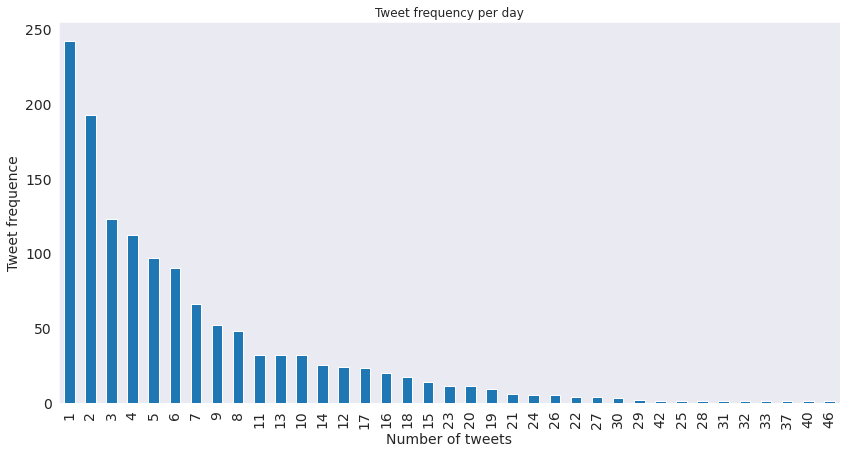

In [82]:
#Tweet frequency per day
elon_musk.groupby('date').tweet.count().value_counts().plot.bar(figsize=(14, 7), fontsize=14)
plt.xlabel("Number of tweets", fontsize=14)
plt.ylabel("Tweet frequence", fontsize=14)
plt.title("Tweet frequency per day")
plt.show()

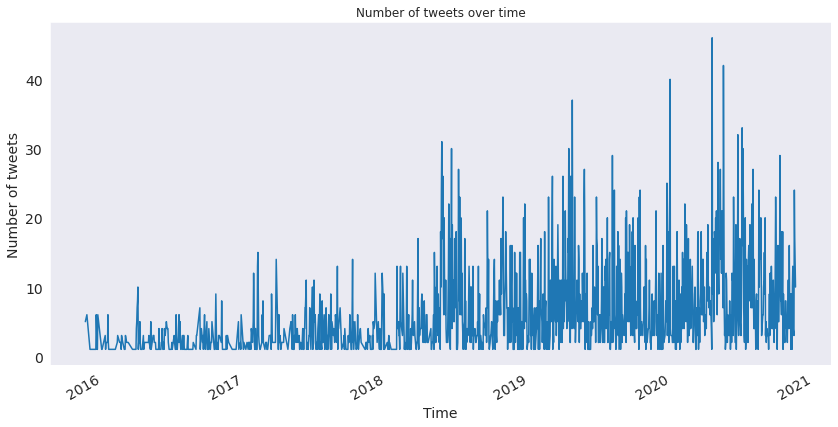

In [81]:
elon_musk.groupby('date').tweet.count().plot(figsize=(14, 7), fontsize=14)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Number of tweets", fontsize=14)
plt.title("Number of tweets over time")
plt.show()

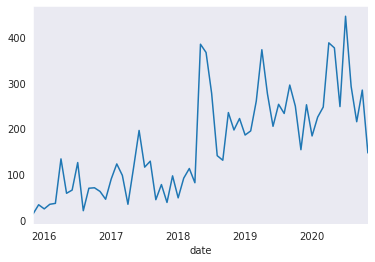

In [13]:
#Likes over time
elon_musk.resample('M').count()['likes_count'].plot()

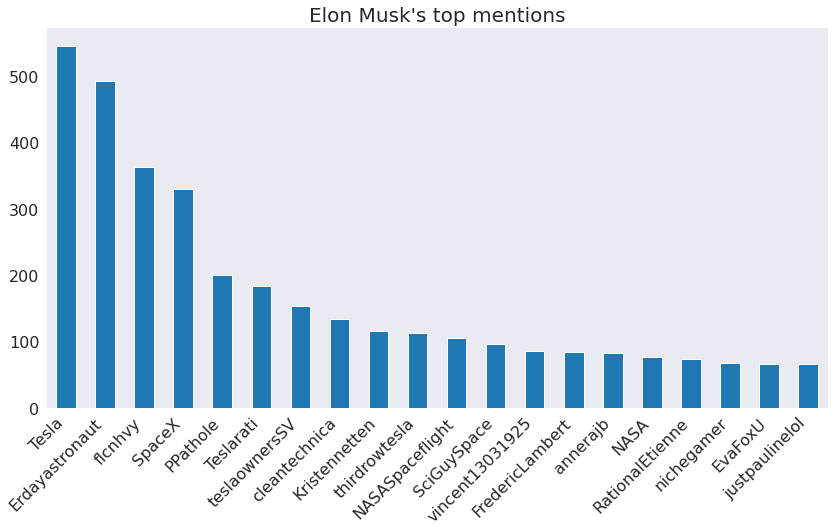

In [83]:
#Elon Musk's top mentions
import itertools
c = list(
itertools.chain(
    *elon_musk.tweet.map(lambda t: [handle.replace(":", "")[1:] for handle in t.split(" ") 
                            if '@' in handle.replace(":", "")]).tolist()))
pd.Series(c).value_counts().head(20).plot.bar(
    figsize=(14, 7), fontsize=16)
plt.gca().set_title("Elon Musk's top mentions", fontsize=20)
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=45, ha='right', fontsize=16)
pass

## Preprocessing

The first step was to remove common elements deemed unnecessary for analysis. These include punctuation, stop words (such as ‘a’, ‘an’ and ‘the’) and Twitter handles, identified by ‘@’ prefix. We also changed all words in the tweets to lower case. 

Next, the team simplified inflected forms of a word through the process of lemmatization. Simply put, words of different forms are replaced with its root form. For example, the words “car”, “cars”, “car’s” and “cars’” are normalized to “car”.

After lemmatization, we grouped tweets made on the same date together and concatenated them.

In [15]:
import nltk

# Importing tokenizing
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()

# Importing  stopwords 
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# Importing punctuations
nltk.download('punkt')
from string import punctuation

# Spacy
import spacy
nlp = spacy.load("en")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [16]:
# Importing preprocessor
!pip install tweet-preprocessor
import preprocessor as p

In [17]:
#Setting options for the cleaner to delete from the tweet
p.set_options(p.OPT.RESERVED, p.OPT.URL, p.OPT.MENTION)

In [18]:
# Cleaning the tweets
elon_musk['tweet_clean'] = [p.clean(tweet) for tweet in elon_musk['tweet']]

In [19]:
#Remove amp
elon_musk['tweet_clean'] = elon_musk['tweet_clean'].replace('&amp;','', regex=True)

Note: We keep punctuations, upper cases and smileys as they have an effect on sentiment analysis

In [20]:
# Create list with lemmatized tokens, only incl. nouns, pronouns, adjectives, adverbes and verbes that are not in stopwords
tokens = []

for tweet in nlp.pipe(elon_musk['tweet_clean']):
  tweet_tok = [token.lemma_ for token in tweet if token.pos_ in ['NOUN', 'PROPN', 'ADJ', 'ADV', 'VERB']] 
  tokens.append(tweet_tok)

In [21]:
elon_musk['tokens'] = tokens

In [22]:
#Removing stopwords
elon_musk['tokens'] = elon_musk['tokens'].apply(lambda x: [token for token in x if token not in stop_words])

In [23]:
#Make tokens into string
elon_musk["tweet_clean_string"] = elon_musk["tokens"].map(lambda row: " ".join(row))

In [24]:
#Removing empty rows in tweet_clean_string

elon_musk['tweet_clean_string'].replace("",float("NaN"), inplace=True)

elon_musk.dropna(subset = ['tweet_clean_string'], inplace=True)

elon_musk.head()

,username,tweet,replies_count,retweets_count,likes_count,tweet_clean,tokens,tweet_clean_string
date,,,,,,,,
2020-11-16,elonmusk,@Maisie_Williams 🎶 Toss a bitcoin to ur Witcher 🎶,1148,3448,66981,🎶 Toss a bitcoin to ur Witcher 🎶,"[🎶, Toss, bitcoin, ur, Witcher, 🎶]",🎶 Toss bitcoin ur Witcher 🎶
2020-11-16,elonmusk,@Kristennetten 😉,100,37,2203,😉,[😉],😉
2020-11-16,elonmusk,"@WhatsupFranks @michaelmina_lab CureVac, Moder...",72,75,1090,"CureVac, Moderna a few others. Tesla makes th...","[CureVac, Moderna, Tesla, make, machine, CureV...",CureVac Moderna Tesla make machine CureVac use...
2020-11-16,elonmusk,@michaelmina_lab Creating synthetic mRNA for c...,96,90,1221,Creating synthetic mRNA for cures/vaccines is ...,"[create, synthetic, mrna, cure, vaccine, futur...",create synthetic mrna cure vaccine future medi...
2020-11-16,elonmusk,@michaelmina_lab Great thread,46,40,825,Great thread,"[great, thread]",great thread


In [25]:
#Removing bottom 10% tweets with the least likes per year

for year in elon_musk.index.year:
  x = (elon_musk.likes_count > elon_musk.likes_count.quantile(0.1))

In [26]:
elon_musk['drop_likes'] = x

In [27]:
elon_musk = elon_musk[elon_musk.drop_likes == True]

In [28]:
elon_musk.drop('drop_likes', axis=1,inplace=True)

In [29]:
!pip install wordcloud
from wordcloud import WordCloud

from PIL import Image
import numpy as np

In [143]:
mask = np.array(Image.open('https://github.com/MariaRosendal/Tesla-tweets/blob/main/twitter_mask.png'))
wc = WordCloud(
    mask=mask, background_color="white",
    max_words=2000, max_font_size=256,
    random_state=42, width=mask.shape[1],
    height=mask.shape[0])
wc.generate(' '.join(elon_musk['tweet_clean_string']))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

FileNotFoundError: ignored

**Sentiment analysis**

Sentiment analysis in NLP identifies the emotive state of a particular text. It ranges from positive to neutral to negative. We used this as an indication of Musk’s emotion for the day, which we later compared to Tesla stock behaviour for the corresponding day.

We used the nltk library—an NLP library—to calculate the sentiment. After identifying emotive states (Pos – Positive, Neg – Negative, Neu – Neutral) of each day’s tweets, we compounded the 3 emotive states to form an overall indicator (named Compound), ranging from -1 to 1. The negative and positive signs indicate negative and positive sentiments respectively, with size of the value indicating the strength of the sentiment.

In [31]:
# Too apply the sentiment score for each day we firstly concatenate the tweets
elon_musk_daily = pd.DataFrame(elon_musk.groupby(elon_musk.index).tweet_clean_string.apply(' '.join))
elon_musk_daily.columns =['conc_tweet']

In [32]:
#Importing sentiment analyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

analyzer = SentimentIntensityAnalyzer()

#Generrating sentiment scores for each tweet and a compound (including all scores)
elon_musk_daily['neg_sentiment'] = elon_musk_daily['conc_tweet'].apply(lambda x:analyzer.polarity_scores(x)['neg'])
elon_musk_daily['neu_sentiment'] = elon_musk_daily['conc_tweet'].apply(lambda x:analyzer.polarity_scores(x)['neu'])
elon_musk_daily['pos_sentiment'] = elon_musk_daily['conc_tweet'].apply(lambda x:analyzer.polarity_scores(x)['pos'])
elon_musk_daily['compound_sentiment'] = elon_musk_daily['conc_tweet'].apply(lambda x:analyzer.polarity_scores(x)['compound'])


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [33]:
#Let's see if the sentiment analysis was incorporated in the dataframe
elon_musk_daily.head()

,conc_tweet,neg_sentiment,neu_sentiment,pos_sentiment,compound_sentiment
date,,,,,
2015-11-20,sound perfect enterprise hell Should mention i...,0.092,0.701,0.206,0.6908
2015-11-24,credit 1st reusable suborbital rocket go X-15 ...,0.026,0.814,0.160,0.8126
2015-12-02,give talk Sorbonne,0.000,1.000,0.000,0.0000
2015-12-03,good summary talk Paris climate change,0.000,0.633,0.367,0.4404
2015-12-06,good luck Cygnus launch,0.000,0.253,0.747,0.7096


In [34]:
#Let's see how many rows we have now
elon_musk_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1310 entries, 2015-11-20 to 2020-11-16
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   conc_tweet          1310 non-null   object 
 1   neg_sentiment       1310 non-null   float64
 2   neu_sentiment       1310 non-null   float64
 3   pos_sentiment       1310 non-null   float64
 4   compound_sentiment  1310 non-null   float64
dtypes: float64(4), object(1)
memory usage: 61.4+ KB


In [35]:
# We now drop all rows that are neither classified as neg, neu or pos (as they would only create noise in the model)
elon_musk_daily = elon_musk_daily[~((elon_musk_daily.neg_sentiment == 0) & (elon_musk_daily.neu_sentiment == 0) & (elon_musk_daily.pos_sentiment == 0))]

#Let's have a look at the dataframe again
elon_musk_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1309 entries, 2015-11-20 to 2020-11-16
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   conc_tweet          1309 non-null   object 
 1   neg_sentiment       1309 non-null   float64
 2   neu_sentiment       1309 non-null   float64
 3   pos_sentiment       1309 non-null   float64
 4   compound_sentiment  1309 non-null   float64
dtypes: float64(4), object(1)
memory usage: 61.4+ KB


In [36]:
#Also adding the number of tweets per day, number of likes, retweets & comments to the dataframe as an explanatory variables

# Number of tweets per day
elon_musk_daily['tweets_count'] = elon_musk.groupby(elon_musk.index).tweet.count()

# Number of likes per day
elon_musk_daily['likes_count'] = elon_musk.groupby(elon_musk.index).likes_count.sum()

# Number of retweets per day
elon_musk_daily['retweets_count'] = elon_musk.groupby(elon_musk.index).retweets_count.sum()

# Number of comments per day
elon_musk_daily['comments_count'] = elon_musk.groupby(elon_musk.index).replies_count.sum()

In [37]:
elon_musk_daily

,conc_tweet,neg_sentiment,neu_sentiment,pos_sentiment,compound_sentiment,tweets_count,likes_count,retweets_count,comments_count
date,,,,,,,,,
2015-11-20,sound perfect enterprise hell Should mention i...,0.092,0.701,0.206,0.6908,5,12112,7551,1333
2015-11-24,credit 1st reusable suborbital rocket go X-15 ...,0.026,0.814,0.160,0.8126,6,12194,5706,638
2015-12-02,give talk Sorbonne,0.000,1.000,0.000,0.0000,1,1070,326,111
2015-12-03,good summary talk Paris climate change,0.000,0.633,0.367,0.4404,1,2310,1531,178
2015-12-06,good luck Cygnus launch,0.000,0.253,0.747,0.7096,1,723,142,25
...,...,...,...,...,...,...,...,...,...
2020-11-12,🤣 🤣 👍 astronaut fly Sat night Cape first opera...,0.000,0.651,0.349,0.7096,3,107401,8692,1830
2020-11-13,case close soon fwiw lab speak think accurate ...,0.109,0.670,0.221,0.9923,24,1373305,209898,75966
2020-11-14,super cautious expect step forward back Lot ne...,0.025,0.785,0.190,0.9701,17,320733,18048,10548


## Stock preprocessing and visualization

In [38]:
!pip install pandas-datareader

In [39]:
# Importing packages
import pandas_datareader as dr
from pandas_datareader import data
import matplotlib.pyplot as plt
% matplotlib inline
import pandas as pd

In [40]:
# Getting the Tesla stock data
tesla = dr.data.get_data_yahoo('tsla', start='2015-11-19', end='2020-11-16')

In [41]:
#Let's have a look
tesla

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-11-19,45.237999,44.060001,44.108002,44.360001,12522000.0,44.360001
2015-11-20,45.000000,42.716000,44.698002,44.001999,22003500.0,44.001999
2015-11-23,43.835999,42.936001,43.470001,43.549999,12631000.0,43.549999
2015-11-24,44.200001,43.000000,43.074001,43.650002,12401500.0,43.650002
2015-11-25,46.166000,44.076000,44.268002,45.928001,19954000.0,45.928001
...,...,...,...,...,...,...
2020-11-10,420.089996,396.029999,420.089996,410.359985,30284200.0,410.359985
2020-11-11,418.700012,410.579987,416.450012,417.130005,17357700.0,417.130005
2020-11-12,423.000000,409.519989,415.049988,411.760010,19855100.0,411.760010


In [42]:
# Change index column into pandas datetime
tesla.index = pd.to_datetime(tesla.index)

In [43]:
tesla.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-11-19,45.237999,44.060001,44.108002,44.360001,12522000.0,44.360001
2015-11-20,45.000000,42.716000,44.698002,44.001999,22003500.0,44.001999
2015-11-23,43.835999,42.936001,43.470001,43.549999,12631000.0,43.549999
2015-11-24,44.200001,43.000000,43.074001,43.650002,12401500.0,43.650002
2015-11-25,46.166000,44.076000,44.268002,45.928001,19954000.0,45.928001


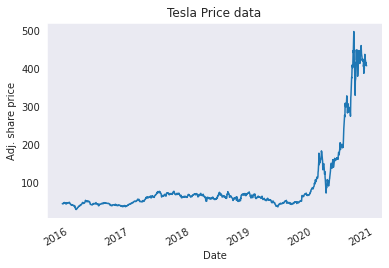

In [44]:
# Visualizing the adjusted close price
tesla['Adj Close'].plot()
plt.xlabel("Date")
plt.ylabel("Adj. share price")
plt.title("Tesla Price data")
plt.show()

In [45]:
# Calculating the daily returns (in %)
tesla['daily_change'] = tesla['Adj Close'].pct_change()*100

In [46]:
print("Tesla daily returns:")
print(tesla['daily_change'].head(10))

Tesla daily returns:
Date
2015-11-19         NaN
2015-11-20   -0.807037
2015-11-23   -1.027225
2015-11-24    0.229626
2015-11-25    5.218785
2015-11-27    0.857858
2015-11-30   -0.582877
2015-12-01    3.009645
2015-12-02   -2.192337
2015-12-03    0.310360
Name: daily_change, dtype: float64


In [47]:
# Pushing daily change one day back (so that these are predicted values)
tesla["daily_change_pred"] = tesla['daily_change'].shift(-1)

In [48]:
# We wish to predict if stock prices increase or decrease. Thus, we transform daily changes to categorical variables

change_categorical = []

for row in tesla['daily_change_pred']:
    if row > 0:
        change_categorical.append('Increase')
    else: 
      change_categorical.append('Decrease')

# OBS: As we only have one neutral observation we set <=0 as a decrease
# in order for our machine learning models to predict this (binary input)

tesla['change_categorical'] = change_categorical

In [49]:
# Drop first column (NaN columns)
tesla.dropna(inplace=True)

In [50]:
tesla.head(20)

,High,Low,Open,Close,Volume,Adj Close,daily_change,daily_change_pred,change_categorical
Date,,,,,,,,,
2015-11-20,45.000000,42.716000,44.698002,44.001999,22003500.0,44.001999,-0.807037,-1.027225,Decrease
2015-11-23,43.835999,42.936001,43.470001,43.549999,12631000.0,43.549999,-1.027225,0.229626,Increase
2015-11-24,44.200001,43.000000,43.074001,43.650002,12401500.0,43.650002,0.229626,5.218785,Increase
2015-11-25,46.166000,44.076000,44.268002,45.928001,19954000.0,45.928001,5.218785,0.857858,Increase
2015-11-27,46.450001,45.402000,46.212002,46.321999,9747000.0,46.321999,0.857858,-0.582877,Decrease
2015-11-30,46.855999,45.816002,46.358002,46.051998,13299000.0,46.051998,-0.582877,3.009645,Increase
2015-12-01,47.599998,46.209999,46.212002,47.438000,18670000.0,47.438000,3.009645,-2.192337,Decrease
2015-12-02,47.720001,46.245998,47.400002,46.397999,14907500.0,46.397999,-2.192337,0.310360,Increase
2015-12-03,47.490002,46.000000,47.096001,46.542000,14698000.0,46.542000,0.310360,-1.001245,Decrease


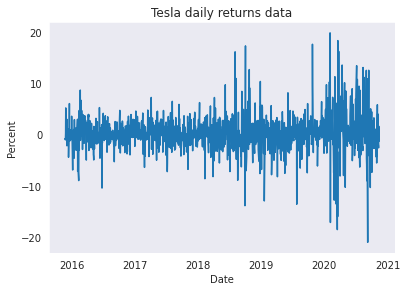

In [51]:
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.plot(tesla['daily_change'])
ax1.set_xlabel("Date")
ax1.set_ylabel("Percent")
ax1.set_title("Tesla daily returns data")
plt.show()

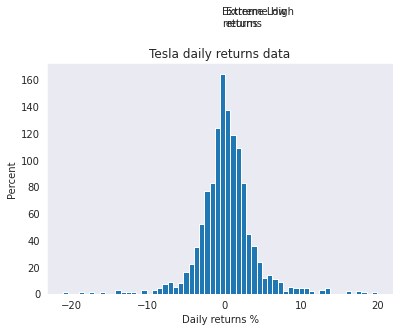

In [52]:
# Plotting the returns in a histogram to get a sense of the distribution
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
tesla['daily_change'].plot.hist(bins = 60)
ax1.set_xlabel("Daily returns %")
ax1.set_ylabel("Percent")
ax1.set_title("Tesla daily returns data")
ax1.text(-0.35,200,"Extreme Low\nreturns")
ax1.text(0.25,200,"Extreme High\nreturns")
plt.show()

In [53]:
# Calculating the mean, standard deviation and other stats
tesla.describe()

,High,Low,Open,Close,Volume,Adj Close,daily_change,daily_change_pred
count,1255.000000,1255.000000,1255.000000,1255.000000,1.255000e+03,1255.000000,1255.000000,1255.000000
mean,90.836985,86.729767,88.840588,88.871335,4.104897e+07,88.871335,0.241671,0.242234
std,92.855403,87.340588,90.279340,90.236548,2.977979e+07,90.236548,3.599398,3.599289
min,30.993999,28.209999,28.464001,28.733999,3.540000e+06,28.733999,-21.062826,-21.062826
25%,47.104000,45.640999,46.348001,46.430000,2.236450e+07,46.430000,-1.404937,-1.404937
50%,61.689999,59.700001,60.675999,60.799999,3.214310e+07,60.799999,0.121555,0.121555
75%,71.505001,69.410000,70.586998,70.438999,4.809550e+07,70.438999,1.831452,1.831452
max,502.489990,470.510010,502.140015,498.320007,3.046940e+08,498.320007,19.894863,19.894863


## Combining the two dataframes

In [54]:
# The dataframes have different lengths which make sense due to trading days excluding weekends and holidays
# Moreover, there are some business days where there are no tweets
print(elon_musk_daily.shape)
print(tesla.shape)

(1309, 9)
(1255, 9)


In [55]:
# Left merged is used to only include trading days (excl. weekends and holidays)
merged = pd.merge(tesla[['change_categorical', 'daily_change_pred', 'Volume', 'daily_change']], elon_musk_daily[['neg_sentiment', 'neu_sentiment','pos_sentiment','compound_sentiment']], left_index=True, right_index=True, how='left')

In [56]:
# Let's see what data looks like
merged.head(20)

,change_categorical,daily_change_pred,Volume,daily_change,neg_sentiment,neu_sentiment,pos_sentiment,compound_sentiment
Date,,,,,,,,
2015-11-20,Decrease,-1.027225,22003500.0,-0.807037,0.092,0.701,0.206,0.6908
2015-11-23,Increase,0.229626,12631000.0,-1.027225,NaN,NaN,NaN,NaN
2015-11-24,Increase,5.218785,12401500.0,0.229626,0.026,0.814,0.160,0.8126
2015-11-25,Increase,0.857858,19954000.0,5.218785,NaN,NaN,NaN,NaN
2015-11-27,Decrease,-0.582877,9747000.0,0.857858,NaN,NaN,NaN,NaN
2015-11-30,Increase,3.009645,13299000.0,-0.582877,NaN,NaN,NaN,NaN
2015-12-01,Decrease,-2.192337,18670000.0,3.009645,NaN,NaN,NaN,NaN
2015-12-02,Increase,0.310360,14907500.0,-2.192337,0.000,1.000,0.000,0.0000
2015-12-03,Decrease,-1.001245,14698000.0,0.310360,0.000,0.633,0.367,0.4404


In [57]:
# Creating row classifying if Elon Musk has posted a tweet or not

merged['tweet_posted'] = merged['compound_sentiment'].notna()

merged.head()

,change_categorical,daily_change_pred,Volume,daily_change,neg_sentiment,neu_sentiment,pos_sentiment,compound_sentiment,tweet_posted
Date,,,,,,,,,
2015-11-20,Decrease,-1.027225,22003500.0,-0.807037,0.092,0.701,0.206,0.6908,True
2015-11-23,Increase,0.229626,12631000.0,-1.027225,NaN,NaN,NaN,NaN,False
2015-11-24,Increase,5.218785,12401500.0,0.229626,0.026,0.814,0.160,0.8126,True
2015-11-25,Increase,0.857858,19954000.0,5.218785,NaN,NaN,NaN,NaN,False
2015-11-27,Decrease,-0.582877,9747000.0,0.857858,NaN,NaN,NaN,NaN,False


In [58]:
# Filling forward rows with no tweets
merged['neg_sentiment'].ffill(axis = 0, inplace=True)
merged['neu_sentiment'].ffill(axis = 0, inplace=True)
merged['pos_sentiment'].ffill(axis = 0, inplace=True)
merged['compound_sentiment'].ffill(axis = 0, inplace=True)

In [86]:
# Set sentiment classifier
x = []
for row in merged['compound_sentiment']:
    if row > 0.05:
       x.append('Positive')
    elif row < -0.05:
       x.append('Negative')
    else: 
      x.append('Neutral')

merged['sentiment_classifier'] = x

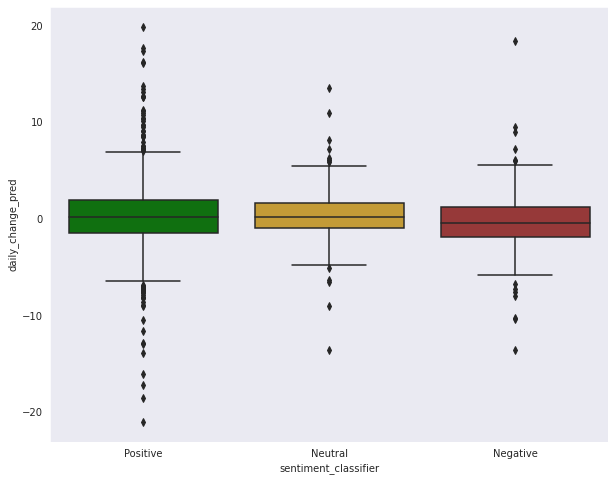

In [95]:
plt.figure(figsize=(10, 8))
sns.boxplot(data=merged, x=merged.sentiment_classifier, y=merged.daily_change_pred, palette=['green','goldenrod','brown'])

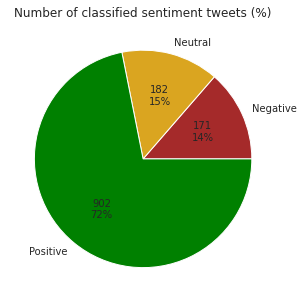

In [91]:
# The distribution of sentiment

def label_function(val):
    return f'{val / 100 * len(merged):.0f}\n{val:.0f}%'

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 5))

merged.groupby('sentiment_classifier').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 10},
                                  colors=['brown', 'goldenrod', 'green'], ax=ax1)
plt.title('Number of classified sentiment tweets (%)')
plt.ylabel('')

plt.show()

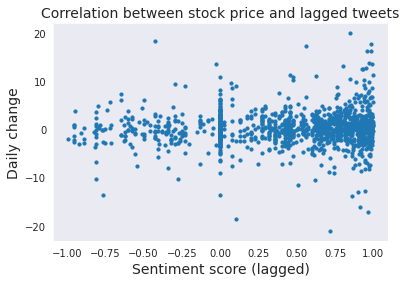

In [62]:
# Show the correlation
plt.scatter(merged.compound_sentiment, merged.daily_change_pred, s=10)
plt.xlabel('Sentiment score (lagged)', fontsize=14)
plt.ylabel('Daily change', fontsize=14)
plt.title('Correlation between stock price and lagged tweets', fontsize=14)
plt.show()

In [63]:
#Calculating the correlation (pearson is the default method)
merged['compound_sentiment'].corr(merged['daily_change_pred'])

0.05393987740266002

In [64]:
merged.drop(['sentiment_classifier'],axis=1, inplace=True)

## Preprocessing of machine learning variables

For starters, we must ensure that the variables in our time series dataset is stationary before we use them as variables in our machine learning algoithms. This is because some of the data we have collected will have non-stationary trends. If spikes are erratic or follow a trend in some variables we cannot be sure that the algorithms will work properly.

To avoid this we test for stationarity in our variables and make sure that the non-stationary variables is transformed to stationary.

**Stationarity**


In [65]:
# Testing for stationarity (i.e. if p-value <= 0.05)

# Import adfuller
from statsmodels.tsa.stattools import adfuller

# Stationarity of hist. adj. close price
print('Stationarity of hist. adj. close price:')
result = adfuller(tesla['Adj Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

# Stationarity of hist. daily change
print("")
print('Stationarity of hist. daily change:')
result = adfuller(merged.daily_change)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

# Stationarity of hist. volume
print("")
print('Stationarity of hist. volume:')
result = adfuller(merged.Volume)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
 
# Stationarity of sentiment score
print("")
print('Stationarity of sentiment score:')
result = adfuller(merged.compound_sentiment)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Stationarity of hist. adj. close price:
ADF Statistic: 2.443726
p-value: 0.999029
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568

Stationarity of hist. daily change:
ADF Statistic: -18.763906
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568

Stationarity of hist. volume:
ADF Statistic: -4.207932
p-value: 0.000639
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568

Stationarity of sentiment score:
ADF Statistic: -11.403875
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


Non-surprisingly, we see that adj. close price is non-stationary which makes sense as the price have increased highly over time (there is a clear trend). Thus, we must use the *change* in stock prices as we see that this is fully stationary.

**Distribution of variables and correlations**

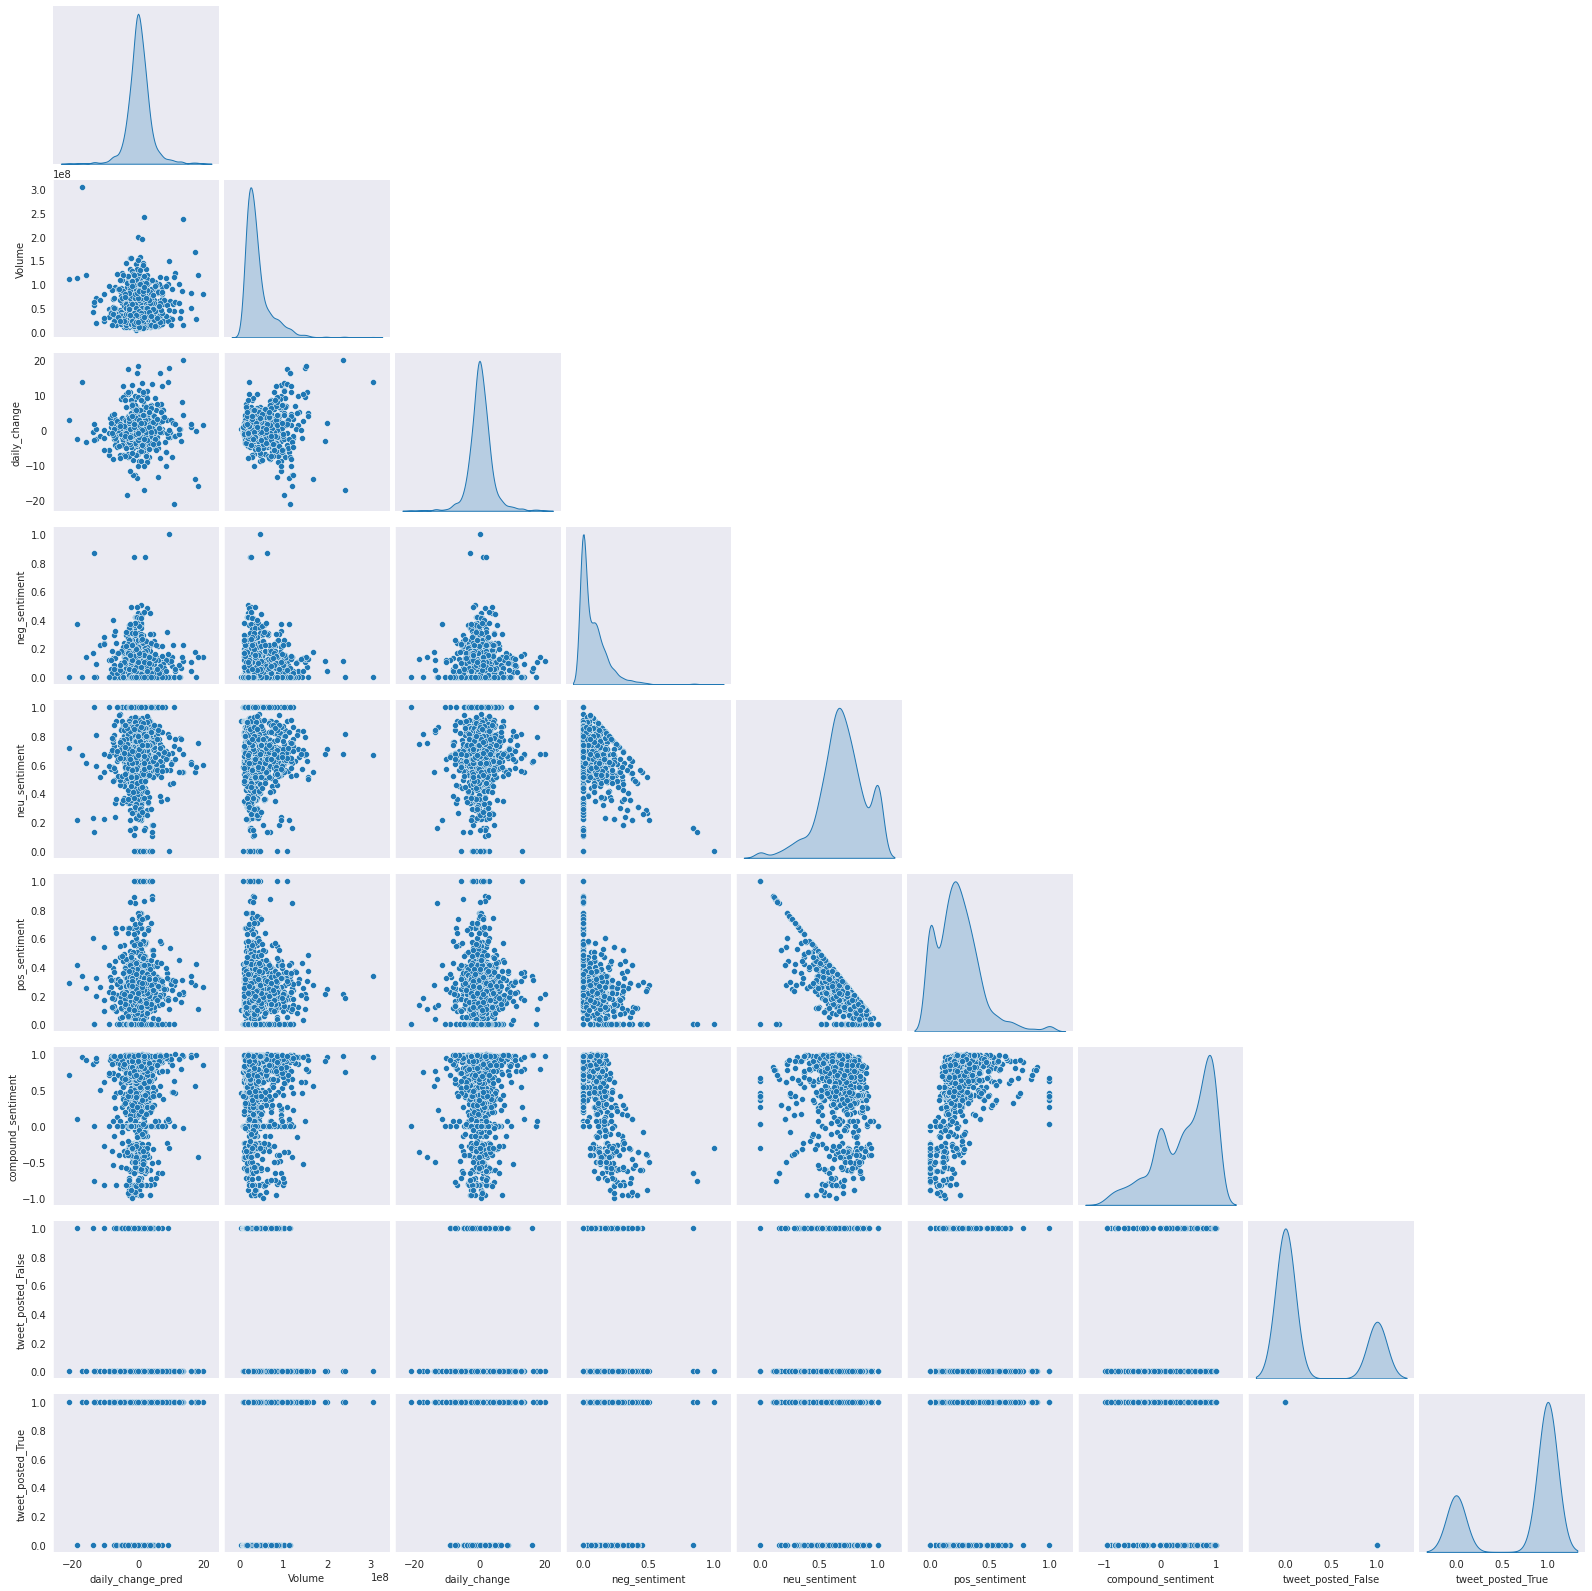

In [101]:
# Let's see a pairplot to visualize the scale of the data we have and the relation between variables
sns.pairplot(merged, corner=True, diag_kind='kde')

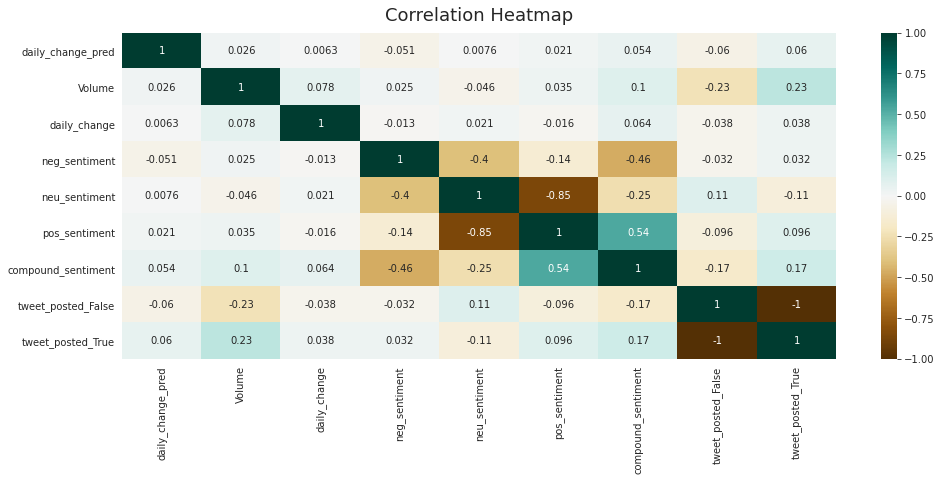

In [100]:
#Visualizing the corelations between all variables
merged.corr()
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(merged.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

## Predicting stock prices using machine learning algorithms (excl. sentiment)

In [67]:
# We must transform our tweets to dummy variables as they are categorical (also evident from above)
merged = pd.get_dummies(merged, columns=(['tweet_posted']))

In [69]:
# From above pairplot, we can also see that the variables have different scales which must be standardized 

# Importing StandardScaler
from sklearn.preprocessing import StandardScaler

# Scaling data
scaled_data = StandardScaler().fit_transform(merged.loc[:,'Volume':'tweet_posted_True'])

In [70]:
scaled_data_df = pd.DataFrame(scaled_data)
scaled_data_df.describe()

,0,1,2,3,4,5,6,7
count,1.255000e+03,1.255000e+03,1.255000e+03,1.255000e+03,1.255000e+03,1.255000e+03,1.255000e+03,1.255000e+03
mean,6.847113e-17,1.601198e-17,-9.713346e-17,4.381732e-16,3.861951e-16,-1.583505e-16,5.974858e-16,-5.997858e-16
std,1.000399e+00,1.000399e+00,1.000399e+00,1.000399e+00,1.000399e+00,1.000399e+00,1.000399e+00,1.000399e+00
min,-1.260046e+00,-5.921265e+00,-7.239777e-01,-3.515891e+00,-1.259831e+00,-2.885229e+00,-6.144974e-01,-1.627346e+00
25%,-6.276711e-01,-4.576500e-01,-7.239777e-01,-5.229448e-01,-6.606213e-01,-8.831699e-01,-6.144974e-01,-1.627346e+00
50%,-2.991766e-01,-3.338446e-02,-3.404397e-01,-1.331624e-03,-9.424460e-02,3.294756e-01,-6.144974e-01,6.144974e-01
75%,2.367156e-01,4.418557e-01,4.122537e-01,6.114373e-01,5.022294e-01,8.686315e-01,1.627346e+00,6.144974e-01
max,8.856681e+00,5.462310e+00,8.864473e+00,1.548315e+00,4.212407e+00,1.132444e+00,1.627346e+00,6.144974e-01


StandardScaler enables us to obtain scaled data with means very close to 0 (note, the values contain high exponents) and the standard deviations close to 1. 

In [71]:
# As we have text values fo y, we must use LabelEncoder to transform to integers

# Importing packages
from sklearn.preprocessing import LabelEncoder

# Defining X and y values (transforming text to integers for y)
X = scaled_data

y = merged.loc[:,'change_categorical']
labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)

In [72]:
# Importing train test split: 
from sklearn.model_selection import train_test_split

In [73]:
# Defining the train (80%) and test (20%) data set (setting shuffle to false in order)
X_train, X_test, y_train, y_test = train_test_split(X, y , train_size=0.8, test_size=0.2, random_state = 0, shuffle=False)

In [74]:
# Importing models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

m_lr = LogisticRegression()
m_rf = RandomForestClassifier()
m_xgb = XGBClassifier()
m_knn = KNeighborsClassifier()
m_svc = SVC()

In [109]:
# Setting parameters for gridsearch
parameters_lr = {'penalty': ['l1', 'l2'], 'C': [1.0, 0.5, 0.1], 'solver': ['liblinear']}
parameters_rf = {'n_estimators':[50, 100, 150, 200, 300], 'criterion':('gini', 'entropy')}
parameters_xgb = {'n_estimators':[50, 100, 150, 200, 300], 'learning_rate': [0.001, 0.005, 0.01, 0.05], 'max_depth': [8, 10, 12, 15], 'gamma': [0.001, 0.005, 0.01, 0.02]}
parameters_knn = {'weights':('uniform', 'distance'), 'n_neighbors':[3, 5, 7, 10, 25]}
parameters_svc = [{'kernel': ['rbf'], 'gamma': [0.1, 1e-3, 1e-4], 'C': [0.1, 1, 10, 100, 1000]},
                  {'kernel': ['linear'], 'C': [0.1, 1, 10, 100, 1000]}]

In [110]:
# Importing evaluation parameters
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, make_scorer

# Importing gridsearch
from sklearn.model_selection import GridSearchCV

# Importing time series split
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=60)

# Set scorer for optimal model
scorer = make_scorer(f1_score)

# Setting grid object using scorer as the scoring method
grid_obj_lr = GridSearchCV(m_lr, parameters_lr, scoring=scorer, cv=tscv)
grid_obj_rf = GridSearchCV(m_rf, parameters_rf, scoring=scorer, cv=tscv)
grid_obj_xgb = GridSearchCV(m_xgb, parameters_xgb, scoring=scorer, cv=tscv)
grid_obj_knn = GridSearchCV(m_knn, parameters_knn, scoring=scorer, cv=tscv)
grid_obj_svc = GridSearchCV(m_svc, parameters_svc, scoring=scorer, cv=tscv)

In [112]:
# Fitting the grid search to the training data
grid_fit_lr = grid_obj_lr.fit(X_train, y_train)
grid_fit_rf = grid_obj_rf.fit(X_train, y_train)
grid_fit_xgb = grid_obj_xgb.fit(X_train, y_train)
grid_fit_knn = grid_obj_knn.fit(X_train, y_train)
grid_fit_svc = grid_obj_svc.fit(X_train, y_train)

In [113]:
# Get the model with the best performance
best_lr = grid_fit_lr.best_estimator_
best_rf = grid_fit_rf.best_estimator_
best_xgb = grid_fit_xgb.best_estimator_
best_knn = grid_fit_knn.best_estimator_
best_svc = grid_fit_svc.best_estimator_

In [114]:
#Let's have a look at the parameters in the best models
print(best_lr)
print(best_rf)
print(best_xgb)
print(best_knn)
print(best_svc)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=

In [115]:
# Fit the best model to the data
print("Logistics Regression:")
print(best_lr.fit(X_train, y_train))
print("Random forest:")
print(best_rf.fit(X_train, y_train))
print("XGBoost:")
print(best_xgb.fit(X_train, y_train))
print("Kneighbors:")
print(best_knn.fit(X_train, y_train))
print("Support Vector Classifier:")
print(best_svc.fit(X_train, y_train))

Logistics Regression:
LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
Random forest:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
XGBoost:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
     

In [116]:
# Printing scores
print("Logistic Regression:\t\t" + str(best_lr.score(X_test, y_test)))
print("Random forest:\t\t\t" + str(best_rf.score(X_test, y_test)))
print("XGBoost:\t\t\t" + str(best_xgb.score(X_test, y_test)))
print("Kneighbors:\t\t\t" + str(best_knn.score(X_test, y_test)))
print("Support Vector Classifier:\t" + str(best_svc.score(X_test, y_test)))

Logistic Regression:		0.5179282868525896
Random forest:			0.545816733067729
XGBoost:			0.5139442231075697
Kneighbors:			0.49800796812749004
Support Vector Classifier:	0.5657370517928287


In [117]:
# Predicting the change in stock price and obtaining the initial labels of change in stock price
y_pred_lr = best_lr.predict(X_test)
true_change_lr = labelencoder_y.inverse_transform(y_test)
predicted_change_lr = labelencoder_y.inverse_transform(y_pred_lr)

# Numerically visualizatin the accuracy of the models
result_lr = pd.DataFrame({'true_change': true_change_lr, 'predicted_change': predicted_change_lr})
pd.crosstab(result_lr.true_change, result_lr.predicted_change)

predicted_change,Decrease,Increase
true_change,,
Decrease,60,48
Increase,73,70


In [118]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.45      0.56      0.50       108
           1       0.59      0.49      0.54       143

    accuracy                           0.52       251
   macro avg       0.52      0.52      0.52       251
weighted avg       0.53      0.52      0.52       251



**Random forest**

In [119]:
# Predicting the change in stock price and obtaining the initial labels of change in stock price
y_pred_rf = best_rf.predict(X_test)
true_change_rf = labelencoder_y.inverse_transform(y_test)
predicted_change_rf = labelencoder_y.inverse_transform(y_pred_rf)

# Numerically visualizatin the accuracy of the models
result_rf = pd.DataFrame({'true_change': true_change_rf, 'predicted_change': predicted_change_rf}) 

pd.crosstab(result_rf.true_change, result_rf.predicted_change)

predicted_change,Decrease,Increase
true_change,,
Decrease,75,33
Increase,81,62


In [120]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.48      0.69      0.57       108
           1       0.65      0.43      0.52       143

    accuracy                           0.55       251
   macro avg       0.57      0.56      0.54       251
weighted avg       0.58      0.55      0.54       251



**XGB**

In [121]:
# Predicting the change in stock price and obtaining the initial labels of change in stock price
y_pred_xgb = best_xgb.predict(X_test)
true_change_xgb = labelencoder_y.inverse_transform(y_test)
predicted_change_xgb = labelencoder_y.inverse_transform(y_pred_xgb)

# Obtaining confusion matrix
result_xgb = pd.DataFrame({'true_change': true_change_xgb, 'predicted_change': predicted_change_xgb}) 

pd.crosstab(result_xgb.true_change, result_xgb.predicted_change)

predicted_change,Decrease,Increase
true_change,,
Decrease,54,54
Increase,68,75


In [122]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.44      0.50      0.47       108
           1       0.58      0.52      0.55       143

    accuracy                           0.51       251
   macro avg       0.51      0.51      0.51       251
weighted avg       0.52      0.51      0.52       251



 **KNeighbors**

In [123]:
# Predicting the change in stock price and obtaining the initial labels of change in stock price
y_pred_knn = best_knn.predict(X_test)
true_change_knn = labelencoder_y.inverse_transform(y_test)
predicted_change_knn = labelencoder_y.inverse_transform(y_pred_knn)

# Obtaining confusion matrix
result_knn = pd.DataFrame({'true_change': true_change_knn, 'predicted_change': predicted_change_knn})

pd.crosstab(result_knn.true_change, result_knn.predicted_change)

predicted_change,Decrease,Increase
true_change,,
Decrease,63,45
Increase,81,62


In [124]:
#Show classification repotr
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.44      0.58      0.50       108
           1       0.58      0.43      0.50       143

    accuracy                           0.50       251
   macro avg       0.51      0.51      0.50       251
weighted avg       0.52      0.50      0.50       251



**SVC**

In [125]:
# Predicting the change in stock price and obtaining the initial labels of change in stock price
y_pred_svc = best_svc.predict(X_test)
true_change_svc = labelencoder_y.inverse_transform(y_test)
predicted_change_svc = labelencoder_y.inverse_transform(y_pred_svc)

# Obtaining confusion matrix
result_svc = pd.DataFrame({'true_change': true_change_svc, 'predicted_change': predicted_change_svc}) 

pd.crosstab(result_svc.true_change, result_svc.predicted_change)

predicted_change,Decrease,Increase
true_change,,
Decrease,36,72
Increase,37,106


In [126]:
#Show classification report
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.49      0.33      0.40       108
           1       0.60      0.74      0.66       143

    accuracy                           0.57       251
   macro avg       0.54      0.54      0.53       251
weighted avg       0.55      0.57      0.55       251



**Pemutation impotance**

In [127]:
# Importing permutation importance
from sklearn.inspection import permutation_importance

Text(0.5, 0, 'Permutation Importance')

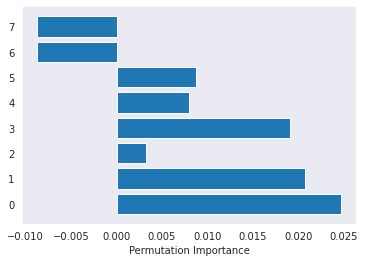

In [128]:
# Visualizaing the permutation importance (the decrease in a model score when a single feature value is randomly shuffled)
# Negative score indicates noise in the model
perm_importance = permutation_importance(best_svc, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(sorted_idx, perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

## Predicting stock prices using machine learning algorithms (incl. sentiment score)

In [129]:
# From above pairplot, we can also see that the variables have different scales which must be standardized 

# Importing StandardScaler
from sklearn.preprocessing import StandardScaler

# Scaling data
scaled_data_s = StandardScaler().fit_transform(merged.loc[:,'neg_sentiment':'compound_sentiment'])
X_s=scaled_data_s

In [130]:
# Defining the train (80%) and test (20%) data set (setting shuffle to false in order)
X_train, X_test, y_train, y_test = train_test_split(X, y , train_size=0.8, test_size=0.2, random_state = 0, shuffle=False)

In [131]:
# Setting grid object using scorer as the scoring method
grid_obj_lr = GridSearchCV(m_lr, parameters_lr, scoring=scorer, cv=10)
grid_obj_rf = GridSearchCV(m_rf, parameters_rf, scoring=scorer, cv=10)
grid_obj_xgb = GridSearchCV(m_xgb, parameters_xgb, scoring=scorer, cv=10)
grid_obj_knn = GridSearchCV(m_knn, parameters_knn, scoring=scorer, cv=10)
grid_obj_svc = GridSearchCV(m_svc, parameters_svc, scoring=scorer, cv=10)

In [132]:
# Fitting the grid search to the training data
grid_fit_lr = grid_obj_lr.fit(X_train, y_train)
grid_fit_rf = grid_obj_rf.fit(X_train, y_train)
grid_fit_xgb = grid_obj_xgb.fit(X_train, y_train)
grid_fit_knn = grid_obj_knn.fit(X_train, y_train)
grid_fit_svc = grid_obj_svc.fit(X_train, y_train)

In [133]:
# Get the model with the best performance
best_lr = grid_fit_lr.best_estimator_
best_rf = grid_fit_rf.best_estimator_
best_xgb = grid_fit_xgb.best_estimator_
best_knn = grid_fit_knn.best_estimator_
best_svc = grid_fit_svc.best_estimator_

In [134]:
#Let's have a look at the parameters in the best models
print(best_lr)
print(best_rf)
print(best_xgb)
print(best_knn)
print(best_svc)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, 

In [135]:
# Fit the best model to the data
print("Logistics Regression:")
print(best_lr.fit(X_train, y_train))
print("Random forest:")
print(best_rf.fit(X_train, y_train))
print("XGBoost:")
print(best_xgb.fit(X_train, y_train))
print("Kneighbors:")
print(best_knn.fit(X_train, y_train))
print("Support Vector Classifier:")
print(best_svc.fit(X_train, y_train))

Logistics Regression:
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
Random forest:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
XGBoost:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        

In [ ]:
#Printing scores
print("Logistic Regression:\t\t" + str(best_lr.score(X_test, y_test)))
print("Random forest:\t\t\t" + str(best_rf.score(X_test, y_test)))
print("XGBoost:\t\t\t" + str(best_xgb.score(X_test, y_test)))
print("Kneighbors:\t\t\t" + str(best_knn.score(X_test, y_test)))
print("Support Vector Classifier:\t" + str(best_svc.score(X_test, y_test)))